In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [734]:
targets_df= pd.read_csv('../0_data/subset_targets.csv')

In [738]:
df = pd.DataFrame(targets_df['pref_name'])
df['type'] = ''

In [740]:
df.to_csv('targettyypes.csv')

In [4]:
from pubval import PubChemValidator
pcv = PubChemValidator(None, None, None)

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [777]:
pcv.load_checkpoint()
print(len(pcv.predictions))

38102


In [778]:
import tqdm
import pandas as pd

df = pd.DataFrame(columns=['tid', 'pref_name', 'lig_chemblid', 'aid', 'outcome', 'title','nnrank'])
count = 0 
acts = list()

inacts= list()
probs= list()
nns = list()
for pred in tqdm.tqdm_notebook(pcv.predictions.keys()):
    lig, targ = pred.split(':')
    try:
        target_synonyms = pcv.targets[targ]['synonyms']
        tid = pcv.targets[targ]['tid']
        pref_name = pcv.targets[targ]['pref_name']
        
        ligand_chemblid = pcv.ligands[lig]['chemblid']
    
        assays = pcv.ligands[lig]['assays']
    except:
        continue
        
    act = 0
    inact = 0
    unspec = 0
    
    nn = pcv.predictions[pred]['nn']
    
    
    for a in assays:
        aid = a[0]
        title = a[2]
        clean_title = pcv.clean_text(title)

        
        num = len(set(target_synonyms).intersection(clean_title.split()))
        if num>0:
            outcome =  a[1]
            if outcome=='Unspecified':
                unspec+=1
            if outcome=='Active':
                #print(aid, clean_title, target_synonyms)
                act+=1
            if outcome=='Inactive':
                inact+=1
            if outcome in ['Active', 'Inactive']:
                df.loc[count] = [tid, pref_name, ligand_chemblid, aid, outcome, title, nn]
                count+=1
    if sum([act, inact])>0:
        prob = pcv.predictions[pred]['prob']
        
        nns.append(nn)
        acts.append(act)
        inacts.append(inact)
        probs.append(float(prob))
        
        #print( act, inact, prob)#, unspec ) 
        
acts = np.array(acts)
inacts = np.array(inacts)
nns =np.array(nns)
probs = np.array(probs)

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [849]:
print(len(inacts))

864


In [850]:
df.sort_values(by='pref_name').to_csv('results.csv')

In [851]:
df

,tid,pref_name,lig_chemblid,aid,outcome,title,nnrank
0,CHEMBL261,Carbonic anhydrase I,CHEMBL2326507,727274,Inactive,inhibition of full length human recombinant fu...,1.5
1,CHEMBL222,Norepinephrine transporter,CHEMBL3126751,1075730,Active,displacement of [3h]nisoxetine from sprague da...,11.5
2,CHEMBL261,Carbonic anhydrase I,CHEMBL215355,271037,Active,inhibition of human cloned ca1 by co2 hydratio...,1.0
3,CHEMBL321,Matrix metalloproteinase 9,CHEMBL43147,310906,Active,inhibition of mmp9,1.0
4,CHEMBL333,Matrix metalloproteinase-2,CHEMBL348335,107154,Active,inhibitory activity against human gelatinase a...,3.0
...,...,...,...,...,...,...,...
1864,CHEMBL216,Muscarinic acetylcholine receptor M1,CHEMBL1724,602247,Inactive,full deck counterscreen for positive allosteri...,1.0
1865,CHEMBL216,Muscarinic acetylcholine receptor M1,CHEMBL1724,602248,Inactive,full deck counterscreen for agonists of the hu...,1.0
1866,CHEMBL216,Muscarinic acetylcholine receptor M1,CHEMBL1724,602250,Inactive,full deck counterscreen for antagonists of the...,1.0
1867,CHEMBL262,Glycogen synthase kinase-3 beta,CHEMBL553,1117336,Active,gsk3b pretreated hct116 viability from cell ti...,59.0


In [852]:
piv = df.pivot_table(index=['pref_name','lig_chemblid'], columns='outcome', aggfunc='size', fill_value=0)


In [853]:
n,x = np.histogram((piv['Active'] - piv['Inactive']).values, bins=100)

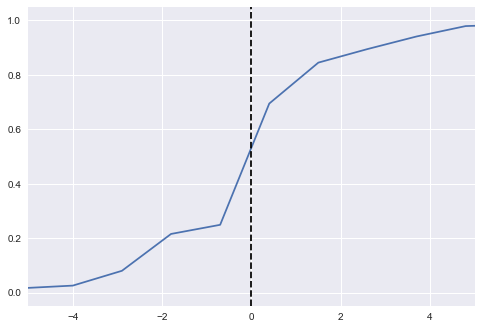

In [854]:
plt.plot(x[:-1], np.cumsum(n) / sum(n))
plt.xlim(-5,5)
plt.axvline(0, c='k', linestyle='--')

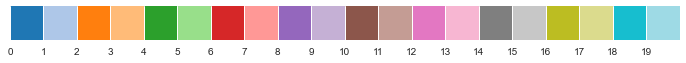

In [855]:
from matplotlib import colors
def makeCmap(name, color_nums):
    cmap = plt.get_cmap(name)
    cmap2 = colors.ListedColormap([cmap.colors[i] for i in color_nums])
    #bounds=[i for i in range(len(color_nums))]
    #norm = colors.BoundaryNorm(bounds, cmap2.N)
    
    return cmap2#, norm
def view_colormap(cmap):
    """Plot a colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    
    fig, ax = plt.subplots(1, figsize=(12, 3),
                           subplot_kw=dict(xticks=range(len(colors)), yticks=[]))
    ax.imshow([colors], extent=[0, len(colors), 0, 1])

    
view_colormap('tab20')

In [856]:
cm = makeCmap('tab20', [1, 2, 4])

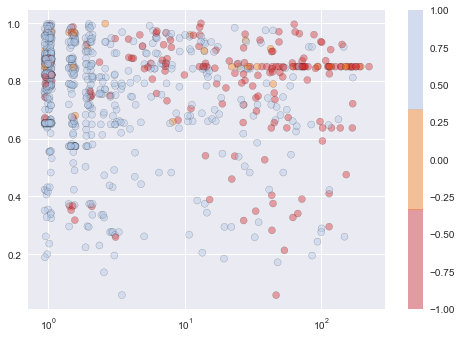

In [857]:
cm = makeCmap('tab20', [6, 2, 1])
jit = np.random.random(len(nns))-0.5
jit /= 8
jit += 1
plt.scatter(nns*jit, 
            probs, 
            c=np.sign(acts-inacts), 
            alpha=0.4, 
            edgecolor='k',
            cmap=cm
           )
plt.colorbar()
plt.xscale('log')

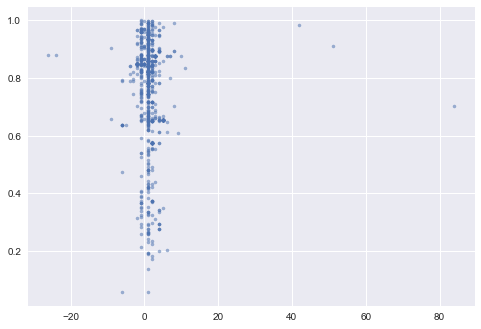

In [858]:
plt.scatter(np.array(acts) - np.array(inacts), 
            [float(i) for i in probs],
           s=10,
           alpha=0.5)

In [859]:
d =np.vstack([np.array(acts),np.array(inacts)])

In [860]:
p = list()
n = list()
checks = np.arange(1,200)
for rank in checks:
    mask = nns>rank

    m = d.T[mask]
    res = (m[:,0] - m[:,1])

    
    p.append((res>0).sum())
    n.append((res<0).sum())
    print(f'RANK:{rank}')
    print('\t', (res>0).sum())
    print('\t',(res<0).sum())

RANK:1
	 362
	 165
RANK:2
	 205
	 150
RANK:3
	 155
	 146
RANK:4
	 139
	 142
RANK:5
	 127
	 139
RANK:6
	 114
	 133
RANK:7
	 109
	 125
RANK:8
	 103
	 123
RANK:9
	 97
	 122
RANK:10
	 95
	 121
RANK:11
	 90
	 119
RANK:12
	 84
	 119
RANK:13
	 83
	 115
RANK:14
	 70
	 111
RANK:15
	 67
	 110
RANK:16
	 63
	 108
RANK:17
	 62
	 107
RANK:18
	 58
	 106
RANK:19
	 56
	 105
RANK:20
	 54
	 104
RANK:21
	 53
	 103
RANK:22
	 52
	 103
RANK:23
	 52
	 101
RANK:24
	 52
	 100
RANK:25
	 49
	 98
RANK:26
	 49
	 97
RANK:27
	 46
	 96
RANK:28
	 43
	 91
RANK:29
	 42
	 91
RANK:30
	 40
	 88
RANK:31
	 40
	 88
RANK:32
	 40
	 87
RANK:33
	 38
	 87
RANK:34
	 38
	 85
RANK:35
	 37
	 83
RANK:36
	 35
	 82
RANK:37
	 34
	 80
RANK:38
	 33
	 80
RANK:39
	 33
	 80
RANK:40
	 33
	 80
RANK:41
	 31
	 80
RANK:42
	 30
	 76
RANK:43
	 30
	 73
RANK:44
	 28
	 71
RANK:45
	 27
	 68
RANK:46
	 26
	 66
RANK:47
	 26
	 66
RANK:48
	 26
	 64
RANK:49
	 26
	 61
RANK:50
	 24
	 60
RANK:51
	 24
	 60
RANK:52
	 24
	 58
RANK:53
	 23
	 57
RANK:54
	 23
	 57
RANK:

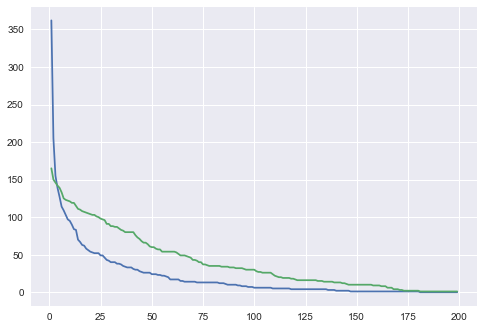

In [861]:
plt.plot(checks, p)
plt.plot(checks, n)

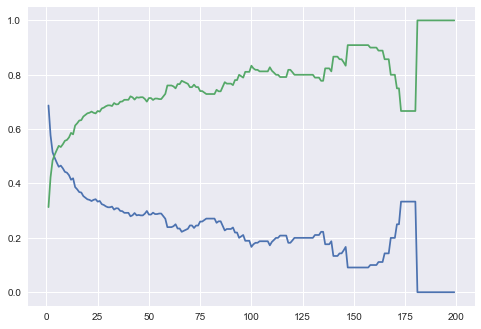

In [862]:
plt.plot(checks, 
         np.array(p) / (np.array(p)+np.array(n)))

plt.plot(checks, 
         np.array(n) / (np.array(p)+np.array(n)))

In [863]:
from scipy.stats import beta
plt.style.use('seaborn')

(0.0, 1.0)

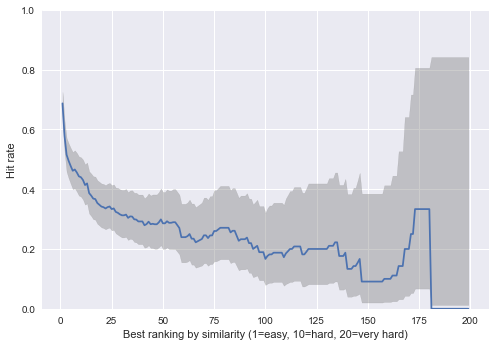

In [864]:

rate = np.array(p) / (np.array(p) + np.array(n))
low = beta.ppf(0.025, np.array(p)+1, np.array(n)+1)
high =beta.ppf(0.975, np.array(p)+1, np.array(n)+1)
plt.fill_between(x=checks,y1=low, y2=high,alpha=0.4, color='grey')
plt.plot(checks, rate)

plt.ylabel('Hit rate')
plt.xlabel('Best ranking by similarity (1=easy, 10=hard, 20=very hard)')
plt.ylim(0,1)

# #rate = np.array(n) / (np.array(p) + np.array(n))
# rate = 1-rate
# #low = beta.ppf(0.025, np.array(n)+1, np.array(p)+1)
# #high =beta.ppf(0.975, np.array(n)+1, np.array(p)+1)
# plt.fill_between(x=checks,y1=1-low, y2=1-high,alpha=0.4, color='grey')
# plt.plot(checks, rate)

# rate = np.array(p) / (np.array(p) + np.array(n))

<BarContainer object of 16 artists>

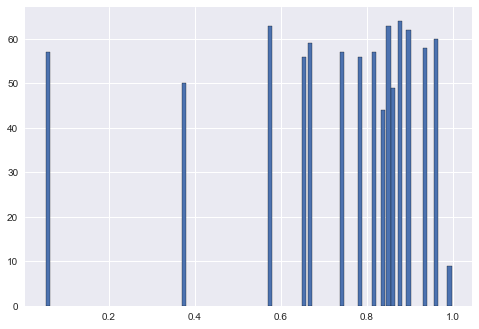

In [795]:
#nbin = 6
#n,x= np.histogram(probs,bins=nbin)
#nbin=6
#n,x=np.histogram(probs, bins=np.linspace(0,1,nbin+1))
n, x = np.histogram(probs, bins=list(probs[probs.argsort()][::len(probs)//15])+[1])

#n, x = np.histogram(probs, bins=bayesian_blocks(probs))
plt.bar(x[:-1], n,edgecolor='k', width=0.01)

Text(0, 0.5, 'Hit rate')

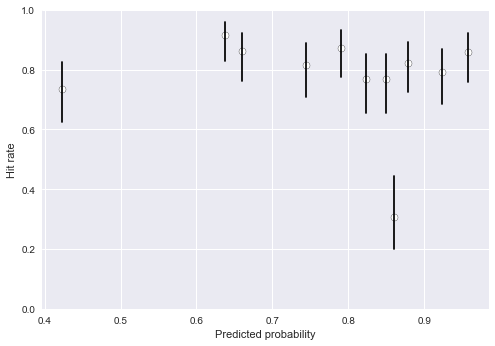

In [796]:
#digits = np.digitize(probs,x)

stride = 12
x = probs[probs.argsort()][::len(probs)//stride]
digits = np.digitize(probs,x)
nbin=len(x)
for b in range(1,nbin):
#for b in range(1,len(x[:-1])):
    mask = digits==b
    
    pos = ((d[0] - d[1])>0)[mask].sum()
    neg = ((d[0] - d[1])<0)[mask].sum()
    
    low = beta.ppf(0.025, pos+1, neg+1)
    high = beta.ppf(0.975, pos+1, neg+1)
    #print(pos/(pos+neg), low, high)
    
    plt.plot([ x[b], x[b]], [low, high], c='k')
    
    plt.scatter([x[b]], [pos/(pos+neg)],edgecolor = 'k', facecolor='white')
    
plt.ylim(0,1)
plt.xlabel('Predicted probability')
plt.ylabel('Hit rate')

### 

In [797]:
df

,tid,pref_name,lig_chemblid,aid,outcome,title,nnrank
0,CHEMBL261,Carbonic anhydrase I,CHEMBL2326507,727274,Inactive,inhibition of full length human recombinant fu...,1.5
1,CHEMBL222,Norepinephrine transporter,CHEMBL3126751,1075730,Active,displacement of [3h]nisoxetine from sprague da...,11.5
2,CHEMBL261,Carbonic anhydrase I,CHEMBL215355,271037,Active,inhibition of human cloned ca1 by co2 hydratio...,1.0
3,CHEMBL321,Matrix metalloproteinase 9,CHEMBL43147,310906,Active,inhibition of mmp9,1.0
4,CHEMBL333,Matrix metalloproteinase-2,CHEMBL348335,107154,Active,inhibitory activity against human gelatinase a...,3.0
...,...,...,...,...,...,...,...
1864,CHEMBL216,Muscarinic acetylcholine receptor M1,CHEMBL1724,602247,Inactive,full deck counterscreen for positive allosteri...,1.0
1865,CHEMBL216,Muscarinic acetylcholine receptor M1,CHEMBL1724,602248,Inactive,full deck counterscreen for agonists of the hu...,1.0
1866,CHEMBL216,Muscarinic acetylcholine receptor M1,CHEMBL1724,602250,Inactive,full deck counterscreen for antagonists of the...,1.0
1867,CHEMBL262,Glycogen synthase kinase-3 beta,CHEMBL553,1117336,Active,gsk3b pretreated hct116 viability from cell ti...,59.0


# Plotting:

In [798]:
def parse_group(group):
    inactive = group['outcome'].str.contains('Inactive').any()
    active = group['outcome'].str.contains('Active').any()
    if inactive and active:
        return 'Both'
    elif active and ~inactive:
        return 'Active'
    elif inactive and ~active:
        return 'Inactive'
    else:
        return False
    
def parse_group2(group):
    inactive = group['outcome'].str.contains('Inactive').sum()
    active = group['outcome'].str.contains('Active').sum()
    if (active - inactive) > 0:
        return 'Active'
    if (active - inactive) < 0:
        return 'Inactive'
    else:
        return 'Both'
    
    
#Mask 1-NN solutions:
#out = df[df['nnrank']>0].groupby(['lig_chemblid', 'pref_name']).apply(parse_group2)

#remove enzymes (anything with 'ase' in it)
out = df[~df['pref_name'].str.contains('ase')].groupby(['lig_chemblid', 'pref_name']).apply(parse_group2)

out_df= pd.DataFrame(out).reset_index().drop('lig_chemblid',axis=1)
out_df.columns=['pref_name', 'activity']

In [799]:
res = piv.reset_index()
res['result'] = np.sign(res['Active'] - res['Inactive'])

In [800]:
res.groupby('pref_name')['result'].sum()

pref_name
3-phosphoinositide dependent protein kinase-1     1
ADAM17                                           -1
Acetylcholinesterase                              4
Alpha-1d adrenergic receptor                      3
Androgen Receptor                                 1
                                                 ..
Tyrosine-protein kinase receptor FLT3            42
Vascular endothelial growth factor receptor 1     0
Vascular endothelial growth factor receptor 2    47
c-Jun N-terminal kinase 1                        -5
c-Jun N-terminal kinase 3                        -1
Name: result, Length: 96, dtype: int64

In [801]:
import altair as alt


In [802]:
temp = out_df.groupby('pref_name').filter(lambda x : len(x)>1)
ch = alt.Chart(temp).mark_bar()

# ch = ch.encode(
#     x = alt.X('pref_name', sort='-y', title='Target preferred name'),
#     y = alt.Y('count()'),
#     color=alt.Color('activity'),
#     order=alt.Order('activity', sort='ascending'),
# )

ch = ch.encode(
    y = alt.Y('pref_name', sort='-x', title='Target preferred name'),
    x = alt.X('count()', title='Count'),
    color=alt.Color('activity'),
    order=alt.Order('activity', sort='ascending'),
    tooltip=['count()',]
).properties(height=850,width=400)

ch.configure_axisY(
titleFontSize=13,
).configure_axisX(
titleFontSize=13
).configure_axisBottom(labelAngle=-35).configure_header(
    titleFontSize=40, 
    labelFontSize=40
).configure_axisY(
    titleAngle=0,
    titleAlign="left",
    titleY=-10,
    titleX=-20,
    titleFontSize=16,
).configure_legend(orient='bottom',labelFontSize=22)

ch.interactive()

alt.Chart(...)

In [803]:
temp = out_df.groupby('pref_name').filter(lambda x : len(x)>2)
ch = alt.Chart(temp).mark_bar()

# ch = ch.encode(
#     x = alt.X('pref_name', sort='-y', title='Target preferred name'),
#     y = alt.Y('count()'),
#     color=alt.Color('activity'),
#     order=alt.Order('activity', sort='ascending'),
# )

ch = ch.encode(
    y = alt.Y('pref_name', sort='-x', title='Target preferred name'),
    x = alt.X('count()', title='Count'),
    color=alt.Color('activity'),
    order=alt.Order('activity', sort='ascending'),
).properties(height=500,width=300)

# ch.configure_axisY(
# titleFontSize=13,
# ).configure_axisX(
# titleFontSize=13
# ).configure_axisBottom(labelAngle=-35).configure_header(
#     titleFontSize=40, 
#     labelFontSize=40
# ).configure_axisY(
#     titleAngle=0,
#     titleAlign="left",
#     titleY=-10,
#     titleX=-20,
#     titleFontSize=16,
# ).configure_legend(orient='bottom',labelFontSize=22)

ch

alt.Chart(...)

In [804]:
ch = alt.Chart(out_df).mark_bar()

ch = ch.encode(
    x = alt.X('pref_name', sort='-y', title='Target preferred name'),
    y = alt.Y('count()'),
    color=alt.Color('activity'),
    order=alt.Order('activity', sort='ascending'),
).properties(height=200,width=750)
ch



alt.Chart(...)

# Getting target classes:

In [891]:
target_types = pd.read_csv('target_classes.csv')

In [892]:
target_types

,chembl_id,organism,pref_name
0,CHEMBL2074,Homo sapiens,Maltase-glucoamylase
1,CHEMBL1971,Homo sapiens,Sulfonylurea receptor 2
2,CHEMBL1827,Homo sapiens,Phosphodiesterase 5A
3,CHEMBL1859,Homo sapiens,Voltage-gated T-type calcium channel alpha-1H ...
4,CHEMBL202,Homo sapiens,Dihydrofolate reductase
...,...,...,...
3073,CHEMBL3989381,Homo sapiens,Hepcidin
3074,CHEMBL3989382,Homo sapiens,Macrophage colony-stimulating factor 1
3075,CHEMBL3989383,Homo sapiens,Tumor necrosis factor receptor superfamily mem...
3076,CHEMBL3989384,Homo sapiens,Cadherin-3


In [893]:
df.merge(target_types, on='pref_name')

,tid,pref_name,lig_chemblid,aid,outcome,title,nnrank,chembl_id,organism
0,CHEMBL261,Carbonic anhydrase I,CHEMBL2326507,727274,Inactive,inhibition of full length human recombinant fu...,1.5,CHEMBL261,Homo sapiens
1,CHEMBL261,Carbonic anhydrase I,CHEMBL215355,271037,Active,inhibition of human cloned ca1 by co2 hydratio...,1.0,CHEMBL261,Homo sapiens
2,CHEMBL261,Carbonic anhydrase I,CHEMBL215276,271037,Active,inhibition of human cloned ca1 by co2 hydratio...,1.0,CHEMBL261,Homo sapiens
3,CHEMBL261,Carbonic anhydrase I,CHEMBL6852,47713,Active,inhibition of human carbonic anhydrase i cai,2.0,CHEMBL261,Homo sapiens
4,CHEMBL261,Carbonic anhydrase I,CHEMBL6852,50367,Active,inhibitory activity against human carbonic anh...,2.0,CHEMBL261,Homo sapiens
...,...,...,...,...,...,...,...,...,...
1826,CHEMBL1914,Butyrylcholinesterase,CHEMBL3604192,1240923,Active,inhibition of equine serum bche using atc iodi...,1.0,CHEMBL1914,Homo sapiens
1827,CHEMBL3973,Fibroblast growth factor receptor 4,CHEMBL3961994,1344879,Active,kinase hotspot xe2 xbf xa2 assay: compounds we...,1.5,CHEMBL3973,Homo sapiens
1828,CHEMBL3973,Fibroblast growth factor receptor 4,CHEMBL3961994,1344879,Active,kinase hotspot xe2 xbf xa2 assay: compounds we...,1.5,CHEMBL3973,Homo sapiens
1829,CHEMBL3973,Fibroblast growth factor receptor 4,CHEMBL3961994,1344881,Active,kinase hotspot xe2 xbf xa2 assay: compounds we...,1.5,CHEMBL3973,Homo sapiens


In [883]:
df

,tid,pref_name,lig_chemblid,aid,outcome,title,nnrank
0,CHEMBL261,Carbonic anhydrase I,CHEMBL2326507,727274,Inactive,inhibition of full length human recombinant fu...,1.5
1,CHEMBL222,Norepinephrine transporter,CHEMBL3126751,1075730,Active,displacement of [3h]nisoxetine from sprague da...,11.5
2,CHEMBL261,Carbonic anhydrase I,CHEMBL215355,271037,Active,inhibition of human cloned ca1 by co2 hydratio...,1.0
3,CHEMBL321,Matrix metalloproteinase 9,CHEMBL43147,310906,Active,inhibition of mmp9,1.0
4,CHEMBL333,Matrix metalloproteinase-2,CHEMBL348335,107154,Active,inhibitory activity against human gelatinase a...,3.0
...,...,...,...,...,...,...,...
1864,CHEMBL216,Muscarinic acetylcholine receptor M1,CHEMBL1724,602247,Inactive,full deck counterscreen for positive allosteri...,1.0
1865,CHEMBL216,Muscarinic acetylcholine receptor M1,CHEMBL1724,602248,Inactive,full deck counterscreen for agonists of the hu...,1.0
1866,CHEMBL216,Muscarinic acetylcholine receptor M1,CHEMBL1724,602250,Inactive,full deck counterscreen for antagonists of the...,1.0
1867,CHEMBL262,Glycogen synthase kinase-3 beta,CHEMBL553,1117336,Active,gsk3b pretreated hct116 viability from cell ti...,59.0
